In [1]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [4]:
# prints descriptive graphs and shapes in order 
# to verify sections are working correctly
PRINT_TEST = True

# Functions for plotting data:
Utility functions for printing results and data analysis

In [5]:


## Prints history of sample along with future values/predicted future with auto limit on Y axes
def sample_window_plot(history, true_future, prediction,past_history,future_target, lim = (0,1)):
  plt.figure(figsize=(12, 6))
  plt.title("One sample of x:history and y:True future")
  num_in = list(range(-len(history),0))
  num_out = len(true_future)
  STEP=1
  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.grid(color='grey', linestyle='-', linewidth=0.5)
  plt.xticks(np.arange(-past_history,future_target, step=1)) 

  plt.show()
    
## Prints history of sample along with future values/predicted future with defined limit on Y axes
def plot_history_true(history, true_future, prediction,past_history,future_target, lim = (0,1)):
  plt.figure(figsize=(12, 6))
  plt.axes(ylim=(-2,2))
  num_in = list(range(-len(history),0))
  num_out = len(true_future)
  STEP=1
  plt.plot(num_in, np.array(history[:, 0]), label='History',scaley = False)
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future',scaley = False)
  plt.legend(loc='upper left')
  plt.grid(color='grey', linestyle='-', linewidth=0.5)
  plt.xticks(np.arange(-past_history,future_target, step=1)) 

  plt.show()

## Prints loss of function along with validation
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

## Prints acc of function along with validation
def plot_train_history_acc(history, title):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(accuracy))

  plt.figure()

  plt.plot(epochs, accuracy, 'b', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
  plt.title(title)
  plt.legend()
  plt.show()

# Data Input:

In [6]:

# 1) Find all the filenames
filenames = []
basepath = 'PML\output'
with os.scandir(basepath) as entries:
    for entry in entries:
        if entry.is_file():
            filenames.append(entry.name)

In [7]:
# 2) Read in the datasets
DATASETS = {}
STATES = []
for filename in filenames:
    DATASETS[filename[:-4]] = pd.read_csv("PML\output\\" + filename)
    STATES.append(filename[:-4])

# Data Preprocessing
1. Scale each cumulative col (cases,tested,etc) by 100k/pop in order\
    to get a per 100k result inorder to normalize data across samples.
    
2. Remove uneeded cols that either provide redundent, or static data

3. Make every state the same length

4. Use data to creat new index, and form a list of dataframes representing each state,\
    then drop Data/density Cols

In [8]:
# 1. Scale

# Converting from actual values to per 100k.
# Formula (cases/pop )*100,000
# every value that would differ based on pop"""

#generator for per100k poo
def gen_per100k(pop):
    #Actual function applied
    def per_100k(val):
        if val == 0:
            return 0
        else:
            return (val*100000)/pop
    return per_100k
# list of cols to scale
scalelist = ["Cases","Difference","positive","negative",\
            "hospitalizedCumulative","death","death","deathIncrease"]
# scale
DATASETS_SCALED = {}
for key,val in DATASETS.items():
    func = gen_per100k(val["Population_Count"][0])
    DATASETS_SCALED[key] = DATASETS[key].copy()
    for col in scalelist:
        DATASETS_SCALED[key][col] = DATASETS_SCALED[key][col].apply(func)

# 2. Remove
DATASETS_SR = {}
droplist = ["People_Total_Tested_Count","recovered","Population_Count","LandArea"]
for key,val in DATASETS_SCALED.items():
    DATASETS_SR[key] = DATASETS_SCALED[key].copy()
    DATASETS_SR[key] = DATASETS_SR[key].drop(columns=droplist)

# 3. Make all states the same length
DATASETS_UF = {}
counts = [len(DATASETS_SR[key].index) for key,val in DATASETS_SR.items()]
for key,val in DATASETS_SR.items():
    DATASETS_UF[key] = DATASETS_SR[key].copy()
    DATASETS_UF[key] = DATASETS_UF[key].head(min(counts))
    

# 4. Index along, convert to list, remove unneded
F_LIST = []
for state in STATES:
    COLNAMES = list(DATASETS_UF[state].columns)
    features_considered = COLNAMES
    features_considered.remove("date")
    features_considered.remove("Density")
    features = DATASETS_UF[state][features_considered].copy()
    features.index = DATASETS_UF[state]['date']
    F_LIST.append(features)


# Print Dataset visualizations

Min state length: 44


CORRALATION MATRIX:  (1.00 = positive corr, -1.00 = negative corr)


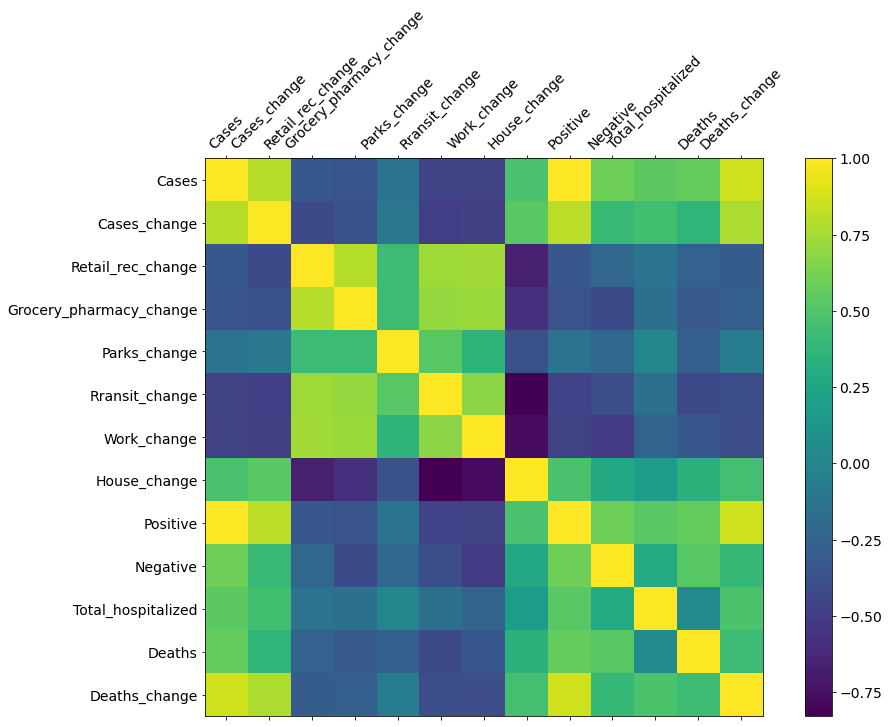

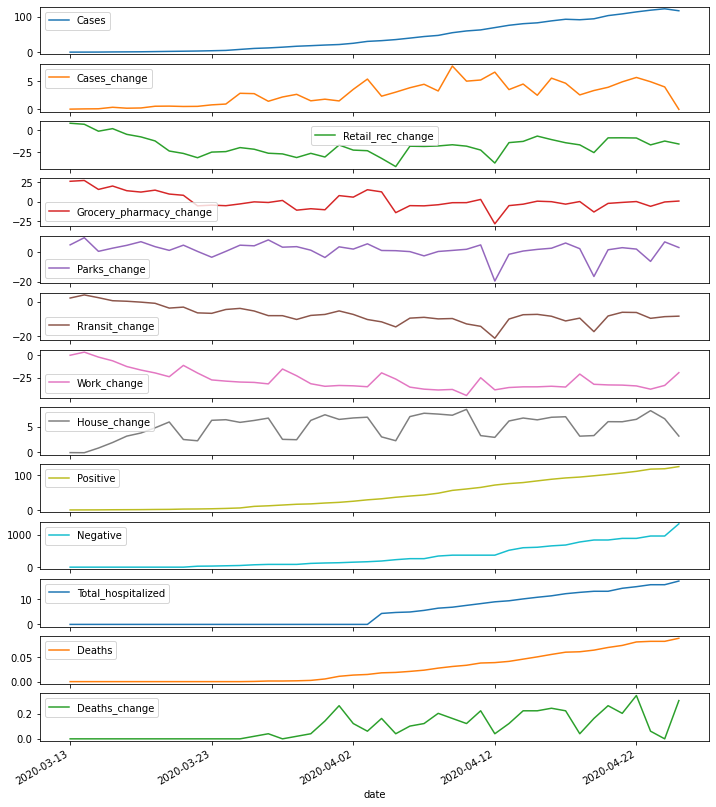

In [9]:
#print logs
if PRINT_TEST:
    print("Min state length: {}".format(min(counts)))
    #print corralation
    print("\n\nCORRALATION MATRIX:  (1.00 = positive corr, -1.00 = negative corr)")
    df =  pd.concat(F_LIST)
    df.columns = ["Cases",
                    "Cases_change",
                    "Retail_rec_change",
                    "Grocery_pharmacy_change",
                    "Parks_change",
                    "Rransit_change",
                    "Work_change",
                    "House_change",
                    "Positive",
                    "Negative",
                    "Total_hospitalized",
                    "Deaths",
                    "Deaths_change"]
    
    f = plt.figure(figsize=(15, 10))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
    plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    df.head(min(counts)).plot(subplots=True,figsize = (12,15))

# Train/test sample creation
1. Define a function to creeate rolling windows of samples<br>
 <br>
2. Define history size, prediction size, prediction collom, and train test split<br>
<br>
3. Split datasets in F_list into samples, and then stack them verticaly so we get\
      x.shape(total number of samples for all states,historysize, number of features)\
      and y.shape(total number of samples, prediction size)<br>
<br>
4. Normalize or Standardize dataset based on each col<br>
<br>
5. Set Batch/buffer size, Insert data into tensorflow dataset in order to efficently\
      sample batches and shuffle dataset<br>

Number of validation cases: 336 
Number of training cases: 1347


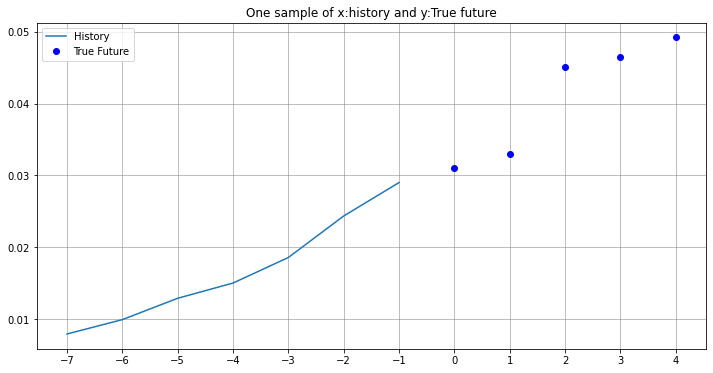

In [10]:
# 1. Function creation

# Parameters: ds-pandas frame of data to use, hist_size-number of historical values
#   pred_size-number of values to use in the future from pred_col
#Results:
# creates a rolling window of slices, for example cosider a 1d input [1,2,3,4,5,6] 
# with a history of 3, and pred of 1, we would get test hist =[[1,2],[2,3][3,4],[4,5]]
# and test_pred = [3,4,5,6]. 

def make_windows(ds, hist_size = 7, pred_size=3, pred_col=0):
    test_ds = ds.values
    history_size = hist_size
    prediction_size = pred_size
    pred_col = pred_col
    test_hist = []
    test_pred = []
    for i in range(0,test_ds.shape[0]-history_size-prediction_size+1):
        test_hist.append(test_ds[i:i+history_size])
        test_pred.append(test_ds[i+history_size:i+history_size+prediction_size,pred_col])
    return test_hist,test_pred


# 2. Define parameters for rolling window and train-test split

history_size = 7
#days to predict
prediction_size = 5
pred_col = 0
#percent to remove for validation
val_percent = .2


# 3. Convert into train-test data

# find the number of datapoints
all_ds = [len(make_windows(F_LIST[x],history_size\
                           ,prediction_size,pred_col)[0]) for x in range(0,len(F_LIST))]
datapoints_size = sum(all_ds)

#create a list of all states history/pred data
all_history = []
all_pred = []
for x in range(0,len(F_LIST)):
    temp_x, temp_y = make_windows(F_LIST[x],history_size,prediction_size,pred_col)
    all_history = all_history + temp_x
    all_pred = all_pred + temp_y
    
#convert into np arrays
ds_x = np.array(all_history)
ds_y = np.array(all_pred)

#shuffle the history/pred slices in order to extract val set randomly (states  w/larger # of days will be represented more)
np.random.seed(0) #set for reuse
p = np.random.permutation(len(ds_x))
ds_x_shuffled = ds_x[p]
ds_y_shuffled = ds_y[p]

#find the number of validation cases needed
num_val_cases = int(datapoints_size*val_percent)
print("Number of validation cases: {} \nNumber of training cases: {}".format(num_val_cases,datapoints_size-num_val_cases))

#seperate into train and test sets
x_test = ds_x[0:num_val_cases]
y_test = ds_y[0:num_val_cases]
x_train = ds_x[num_val_cases:]
y_train = ds_y[num_val_cases:]


# 4. Standarize or normalize dataset

#utils for standarization/normalization
USE_STANDARD = False
if USE_STANDARD:
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
else:
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
#stack x numpy array inorder to fit (col wise) bc in windows of 7
stacked_x_train=x_train.reshape(len(x_train)*history_size,x_train.shape[2])
stacked_x_test=x_test.reshape(len(x_test)*history_size,x_test.shape[2])
#fit the scalers
x_scaler.fit(stacked_x_train)
y_scaler.fit(y_train)

#transofr the training data
stacked_x_train =x_scaler.transform(stacked_x_train)
y_train = y_scaler.transform(y_train)

#transform the validation data (FORGOT TO DO THIS AND WAS CONFUSED BY MSE OF 80)
stacked_x_test = x_scaler.transform(stacked_x_test)
y_test = y_scaler.transform(y_test)

#transform the stacked x data back to right size
x_train = stacked_x_train.reshape(len(x_train),history_size,x_train.shape[2])
x_test = stacked_x_test.reshape(len(x_test),history_size,x_test.shape[2])


# 5. Convert into tf dataset

#set batch/buffer size
BATCH_SIZE = 15
BUFFER_SIZE = 60

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.cache().shuffle(buffer_size=BUFFER_SIZE,seed = 0).batch(BATCH_SIZE).repeat()
test_ds = tf.data.Dataset.from_tensor_slices((x_test,  y_test))
test_ds = test_ds.batch(BATCH_SIZE).repeat()


#print history and prediction
if PRINT_TEST:
    for x, y in train_ds.take(1):
        sample_window_plot(x[0], y[0], np.array([0]),history_size,prediction_size,lim=(0,2))


import seaborn as sns
df = pd.concat(F_LIST["New York"])
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

#builds the model
def build_model(optimizer = "sgd",init_mode = "uniform",lstm1_n = 32, lstm2_n=16):
    model = Sequential()
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_n,\
                                              activation='sigmoid',
                                              return_sequences=True,
                                              input_shape=x_train_single.shape[-2:],\
                                              kernel_initializer=init_mode,dropout = 0.01)))
    model.add(tf.keras.layers.LSTM(lstm2_n, activation='tanh',kernel_initializer=init_mode))
    model.add(tf.keras.layers.Dense(prediction_size,kernel_initializer=init_mode))
    model.compile(optimizer = optimizer, loss="mse",metrics=["accuracy"])
    return model

# Model construction

In [11]:
#builds the model
def build_model(dropout = 0.1,optimizer = "adam",init_mode = "uniform",lstm1_n = 32, lstm2_n=16,loss = 'mean_absolute_error',activation = "relu"):
    model = Sequential()
    model.add(Bidirectional(LSTM(32,
                return_sequences=True,
                input_shape=x_train.shape[-2:],
                recurrent_regularizer=tf.keras.regularizers.l2(10**-6))))
    model.add(LSTM(16, activation='relu'))
    model.add(Dense(prediction_size))
    model.compile(optimizer = "adam", loss="mse",metrics=["accuracy"])
    return model

# K-fold accuracy testing
1. Make a function to print history
2. make a function to take input data, and return it in a split data, with fit on train test, and transformed both
3. perform kfold and output the results
4. plot the collection of accuracys, the mean of folds with std dev, mean of loss with std dev

1//10 folds
   accuracy: 62.22%
2//10 folds
   accuracy: 45.19%
3//10 folds
   accuracy: 70.37%
4//10 folds
   accuracy: 72.59%
5//10 folds
   accuracy: 37.78%
6//10 folds
   accuracy: 74.07%
7//10 folds
   accuracy: 31.85%
8//10 folds
   accuracy: 47.01%
9//10 folds
   accuracy: 56.72%
10//10 folds
   accuracy: 64.18%
Final results: 56.20% (+/- 14.24%)


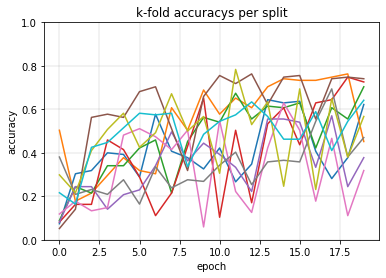

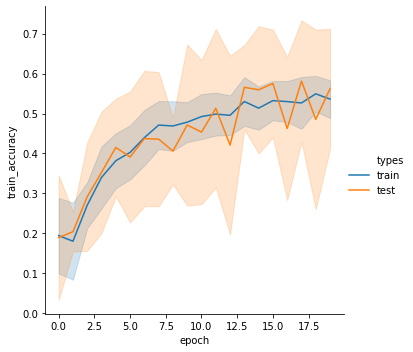

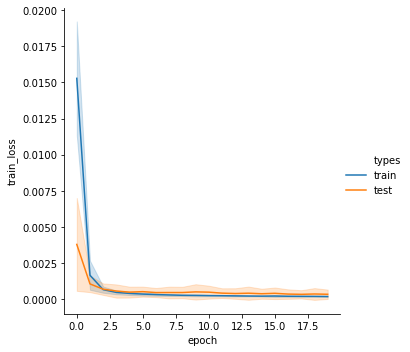

In [12]:
#K folds to perform
K = 10
#batch size for both kfold and training
batch_size = 20
epochs_kfold = 20
# 1. Make a function to print the history of kfold

#prints validation accuracy then validation learning for n historys
def print_historys(history_list):
    accuracy = history_list[0].history['val_accuracy']
    epochs = range(len(accuracy))
    plt.figure()
    plt.axes(ylim=(0,1))
    plt.title('k-fold accuracys per split')
    for history in history_list:
       #plt.plot(history.history['acc'])
        val_accuracy = history.history['val_accuracy']
        plt.plot(epochs, val_accuracy)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.grid(color='grey', linestyle='-', linewidth=0.2)
    #plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    
# 2. Make function to standardize or normalize data per split so only training data is used to fit
def transform_data(x_train,y_train,train_idx,test_idx):
    if USE_STANDARD:
        x_scaler_t = StandardScaler()
        y_scaler_t = StandardScaler()
    else:
        x_scaler_t = MinMaxScaler()
        y_scaler_t = MinMaxScaler()
    #stack x numpy array inorder to fit (col wise) bc in windows of 7
    x_train = x_train.copy()
    y_train = y_train.copy()
    stacked_x_train=x_train.reshape(len(x_train)*history_size,x_train.shape[2])
    #fit the scalers
    x_scaler_t.fit(stacked_x_train)
    y_scaler_t.fit(y_train)
    
    #reform xstack for split
    x_train = stacked_x_train.reshape(len(x_train),history_size,x_train.shape[2])
    #split
    x_train, x_test = x_train[train_idx], x_train[test_index]
    y_train, y_test = y_train[train_idx], y_train[test_idx]
    
    #transform back for fit
    stacked_x_train=x_train.reshape(len(x_train)*history_size,x_train.shape[2])
    stacked_x_test=x_test.reshape(len(x_test)*history_size,x_test.shape[2])
    
    #transform the training data
    stacked_x_train =x_scaler_t.transform(stacked_x_train)
    y_train = y_scaler_t.transform(y_train)
    #transform the validation data (FORGOT TO DO THIS AND WAS CONFUSED BY MSE OF 80)
    stacked_x_test = x_scaler_t.transform(stacked_x_test)
    y_test = y_scaler_t.transform(y_test)

    #transform the stacked x data back to right size
    x_train = stacked_x_train.reshape(len(x_train),history_size,x_train.shape[2])
    x_test = stacked_x_test.reshape(len(x_test),history_size,x_test.shape[2])
    return x_train,y_train,x_test,y_test

    
# 3. Perform kfold on complete dataset and print the results
kf = KFold(n_splits=K)
cvscores=[]
model = build_model()
history_list = []
test_acc_list = []
train_acc_list = []
test_loss_list = []
train_loss_list = []
n = 1
for train_index, test_index in kf.split(x_train):
    #reset weights 
    model = build_model()
    
    #standardize of test data first
    x_train_k, y_train_k,x_test_k, y_test_k = transform_data(ds_x,ds_y,train_index,test_index)
    history = model.fit(x_train_k, y_train_k, epochs=epochs_kfold, batch_size=20,\
                        verbose=0,validation_data=(x_test_k, y_test_k))
    history_list.append(history)
    
    #store data each fold into a list for plotting later
    test_acc_list += history.history['val_accuracy']
    train_acc_list += history.history['accuracy']
    test_loss_list += history.history['val_loss']
    train_loss_list += history.history['loss']
    # evaluate the model
    scores = model.evaluate(x_test_k, y_test_k, verbose=0)
    print("{}//{} folds".format(n,K))
    n += 1
    print("   %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    
    
# 4. Plot the data

#used for seaborn plot
def label(x):
    if(x<K*epochs_kfold):
        return "train"
    else:
        return "test"

print("Final results: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print_historys(history_list)

acc_data = {
    'train_accuracy':train_acc_list+test_acc_list,
    'epoch':[x%epochs_kfold for x in range(0,2*K*epochs_kfold)],
    'types':[label(x) for x in range(0,2*K*epochs_kfold)]
} 
loss_data = {
    'train_loss':train_loss_list+test_loss_list,
    'epoch':[x%epochs_kfold for x in range(0,2*K*epochs_kfold)],
    'types':[label(x) for x in range(0,2*K*epochs_kfold)]
} 

# Create DataFrame 
acc_data = pd.DataFrame(acc_data) 
loss_data = pd.DataFrame(loss_data) 

sns.relplot(x="epoch", y="train_accuracy", kind="line",hue="types", ci="sd", data=acc_data)
sns.relplot(x="epoch", y="train_loss", kind="line",hue="types", ci="sd", data=loss_data)

# Model Training with training split

In [13]:
#define here so we can refit
model = build_model()

In [14]:
EVALUATION_INTERVAL = 200
EPOCHS = 100
#note: batch_size is in kfold in  order to perform with same
model = build_model()
modely = model.fit(x_train,y_train,epochs=EPOCHS,\
                                           batch_size = batch_size,validation_data=(x_test,y_test))

Train on 1347 samples, validate on 336 samples
Epoch 1/100
1347/1347 [==============================] - 4s 3ms/sample - loss: 0.0104 - accuracy: 0.3497 - val_loss: 0.0018 - val_accuracy: 0.1161
Epoch 2/100
1347/1347 [==============================] - 1s 591us/sample - loss: 8.2750e-04 - accuracy: 0.2472 - val_loss: 6.3593e-04 - val_accuracy: 0.2827
Epoch 3/100
1347/1347 [==============================] - 1s 583us/sample - loss: 4.6351e-04 - accuracy: 0.3816 - val_loss: 9.6262e-04 - val_accuracy: 0.3452
Epoch 4/100
1347/1347 [==============================] - 1s 595us/sample - loss: 3.4566e-04 - accuracy: 0.4031 - val_loss: 0.0014 - val_accuracy: 0.1905
Epoch 5/100
1347/1347 [==============================] - 1s 587us/sample - loss: 3.1800e-04 - accuracy: 0.4425 - val_loss: 0.0012 - val_accuracy: 0.3810
Epoch 6/100
1347/1347 [==============================] - 1s 594us/sample - loss: 2.5932e-04 - accuracy: 0.4796 - val_loss: 0.0010 - val_accuracy: 0.6726
Epoch 7/100
1347/1347 [==========

Epoch 53/100
1347/1347 [==============================] - 1s 604us/sample - loss: 1.1755e-04 - accuracy: 0.6295 - val_loss: 3.8108e-04 - val_accuracy: 0.6845
Epoch 54/100
1347/1347 [==============================] - 1s 613us/sample - loss: 1.4327e-04 - accuracy: 0.5160 - val_loss: 2.6117e-04 - val_accuracy: 0.6488
Epoch 55/100
1347/1347 [==============================] - 1s 606us/sample - loss: 9.7527e-05 - accuracy: 0.5590 - val_loss: 2.2198e-04 - val_accuracy: 0.3185
Epoch 56/100
1347/1347 [==============================] - 1s 594us/sample - loss: 8.6360e-05 - accuracy: 0.6214 - val_loss: 2.0383e-04 - val_accuracy: 0.6786
Epoch 57/100
1347/1347 [==============================] - 1s 592us/sample - loss: 8.5640e-05 - accuracy: 0.6140 - val_loss: 1.7583e-04 - val_accuracy: 0.6429
Epoch 58/100
1347/1347 [==============================] - 1s 600us/sample - loss: 9.2662e-05 - accuracy: 0.6132 - val_loss: 2.1912e-04 - val_accuracy: 0.6518
Epoch 59/100
1347/1347 [============================

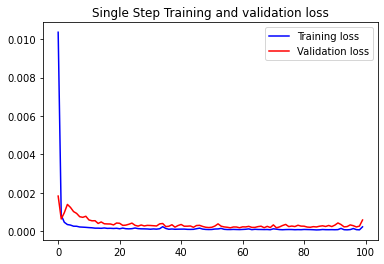

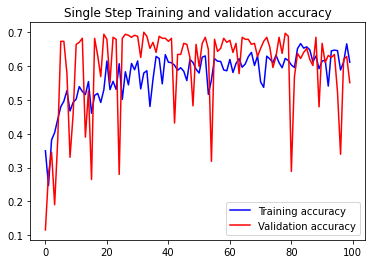

In [15]:
plot_train_history(modely,
                   'Single Step Training and validation loss')
plot_train_history_acc(modely,
                   'Single Step Training and validation accuracy')

(20, 7, 13)
(20, 5)
(20, 5)


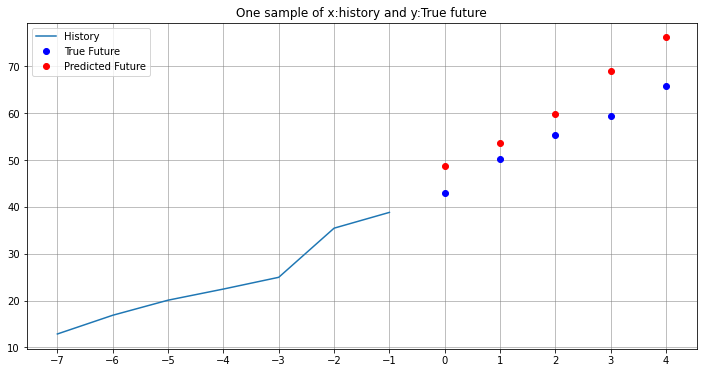

(20, 7, 13)
(20, 5)
(20, 5)


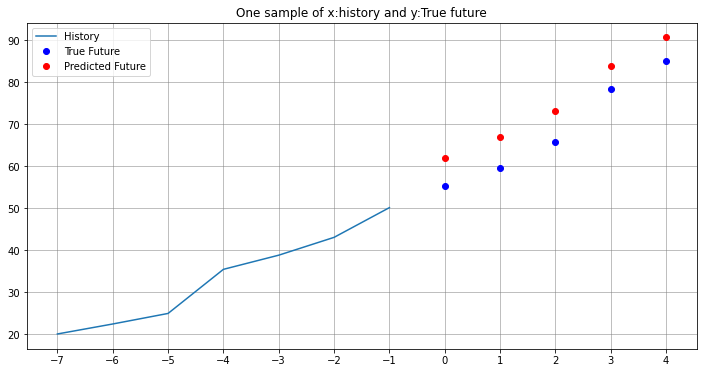

In [17]:
def plot_n_result(n):
    x_temp = x_train[n:n+batch_size,:,:]
    y_temp = y_train[n:n+batch_size,:]
    #y_temp = y_temp.reshape(1,-1)
    print(x_temp.shape)
    print(y_temp.shape)
    p_temp = np.array(model.predict(x_train[n:n+batch_size,:,:]))
    x_unscaled = x_scaler.inverse_transform(x_temp[n])
    y_unscaled = y_scaler.inverse_transform(y_temp)
    p_unscaled = y_scaler.inverse_transform(p_temp)
    print(p_unscaled.shape)
    sample_window_plot(x_unscaled, y_unscaled[n], p_unscaled[n],history_size,prediction_size)
    
for i in range(8,10):
    plot_n_result(i)

In [ ]:
results = multi_step_model.evaluate(x_val_single,y_val_single,verbose=2)

In [ ]:
results

In [ ]:
state = "New Jersey"
COLNAMES = list(DATASETS_SR[state].columns)
features_considered = COLNAMES
features_considered.remove("date")
features_considered.remove("Density")
features = DATASETS_SR[state][features_considered].copy()
features.index = DATASETS_SR[state]['date']
features.head()

data_v = features.values
    #datasets_norm.append((data_v-data_mean)/dat_std)
data_norm = (data_v-data_min)/data_max_min

In [ ]:
import seaborn as sns
df = features
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [ ]:
past_history = 7
future_target = 5
STEP = 1
#FIX HUGE ERROR HERE< need to std not on all
#lets get stacking folks
temp = np.copy(data_norm)
idaho_x, idaho_y = multivariate_data(temp, temp[:, 0], 0,\
                                                   None, past_history,\
                                                   future_target, STEP)


In [ ]:
data_v[:44,0]

In [ ]:
pred = multi_step_model.predict(idaho_x)

In [ ]:
pred.shape

In [ ]:
F_LIST[STATES.index("Idaho")].head()


In [ ]:
data_v[:,0].shape

In [ ]:
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_single,  y_val_single))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
x = np.linspace(0+5, 45+5,num=46)
x1 = np.linspace(10, 20)
plt.figure(figsize=(14, 6))
plt.plot(x, idaho_x[:,6,0]*data_max_min[0]+data_min[0], label='linear')

for i in range(0,pred.shape[0]):
    x_t = np.linspace(i+7,i+7+4,num=5)
    plt.plot(x_t, pred[i]*data_max_min[0]+data_min[0])
plt.xlabel('x label')
plt.ylabel('y label')

plt.title("Simple Plot")

plt.legend()
plt.grid(color='grey', linestyle='-', linewidth=0.2)
plt.xticks(np.arange(0,44, step=1))
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
num_in = list(range(-len(history),0))(len(history))
num_out = len(true_future)
    
plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.grid(color='grey', linestyle='-', linewidth=0.5)
  plt.xticks(np.arange(-past_history,future_target, step=1))
  plt.show()